# Датасет про арендованные квартиры в Барселоне Airbnb
#### Данные крайне разнообразны: есть и название районов, и географические параметры, цены, номера лицензий и т.д.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geotiler

In [4]:
listings = pd.read_csv('listings.csv') 
print(listings.shape[0])  
print(listings.iloc[:5, :2]) 
print(listings.iloc[:5, :3])

19482
      id                                               name
0  18674    Huge flat for 8 people close to Sagrada Familia
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax
2  32711                   Sagrada Familia area - Còrsega 1
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS
      id                                               name  host_id
0  18674    Huge flat for 8 people close to Sagrada Familia    71615
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax    90417
2  32711                   Sagrada Familia area - Còrsega 1   135703
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real    73163
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS    73163


### Cтолбчатая диаграмма, показывающая число квартир по типам

Комментарий к результату: большинство арендаторов предпочитают снимать квартиру или дом целиком, далее по убыванию популярности следует аренда отдельной комнаты. Менее 1% составляет доля тех, кто делит комнату, аналогично для доли тех, кто снимает комнату в отеле. При выборе типа квартиры происходит, вероятнее всего, trade-off между комфортностью проживания и ценой.

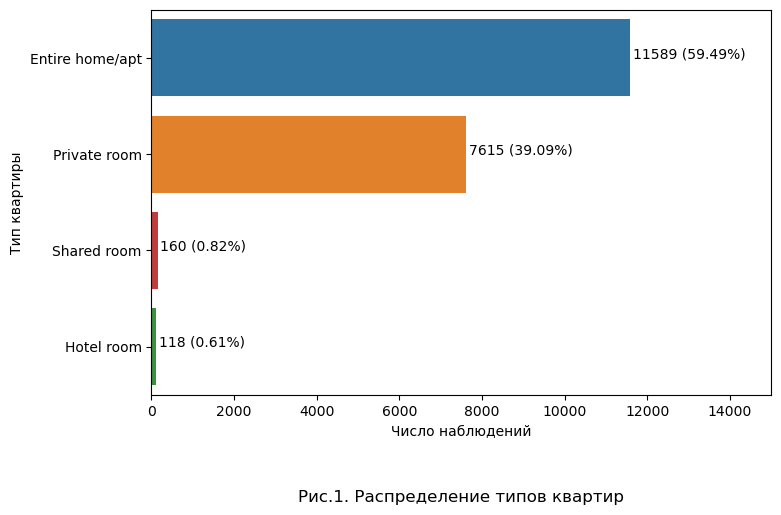

In [10]:
plt.figure(figsize=(8, 5)) 

order = listings['room_type'].value_counts().index # сортировка по убыванию значений

# построение столбчатой диаграммы с подсчетом числа значений переменной 'room_type'
plot = sns.countplot(
    data = listings, # указание на датафрейм
    y ='room_type', # указываем ось y, чтобы график был горизонтальным
    hue ='room_type', # разделение для каждого типа данных
    palette ='tab10', # палитра стандартная
    order = order # порядок по убыванию значений
)

# расчёт доли
total = listings['room_type'].value_counts().sum()
# цикл для добавления подписи значений на график
for i, count in enumerate(listings['room_type'].value_counts()): 
    share = 100 * count / total 
    plt.text(
        count + 60, # положение текста по оси х, чтобы был отступ немного вправо от правого конца столбика
        i, # положение текста по оси y (совпадает с номером типа)
        f'{count} ({share:.2f}%)' # выводим число и процент в формате двух знаков после запятой
    )

plt.title('Рис.1. Распределение типов квартир', y=-0.3)  # заголовок графика с отступом вниз
plt.xlabel('Число наблюдений') # подпись оси X
plt.xlim(0, 15000)
plt.ylabel('Тип квартиры') # подпись оси Y
plt.show()

### Cтолбчатая диаграмма,показывающая число квартир в зависимости от их занятости в течение прошедшего года

Комментарий к результату: большинство квартир по объявлению были заняты более 241 дня за прошедший год, что может говорить о том, что люди заинтересованы именно в долгосрочной аренде. Около 3000 квартир не были сняты за последний год; возможно, это новые предложения от хозяев, которые раньше никогда до этого не предлагали квартиру в аренду.

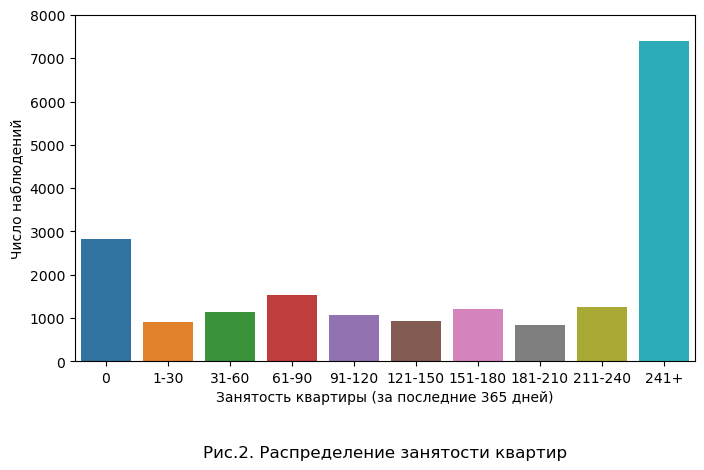

In [18]:
# создаем бины для разделения значений `availability_365` на интервалы
bins = [0, 1, 30, 60, 90, 120, 150, 180, 210, 240, 365]
labels = ['0', '1-30', '31-60', '61-90', '91-120', '121-150', '151-180', 
    '181-210', '211-240', '241+']

# создаем новую колонку с категориями бинов
listings['availability_group'] = pd.cut(
    listings['availability_365'], 
    bins = bins, 
    labels = labels, 
    right=False # интервал включает нижнюю границу, но не верхнюю
)

# построение графика с нужными параметрами
plt.figure(figsize=(8, 4.5))
sns.countplot(
    data = listings, 
    x ='availability_group', # нужны уже вертикальные столбцы, поэтому ось х 
    hue = 'availability_group',
    palette ='tab10', # используем палитру для цветов
    legend = False # отключаем легенду
   )

plt.title('Рис.2. Распределение занятости квартир', y = -0.3)
plt.xlabel('Занятость квартиры (за последние 365 дней)')
plt.ylabel('Число наблюдений')
plt.ylim(0, 8000)
plt.show()

### Круговая диаграмма,показывающая число квартир в зависимости от того, есть ли для них лицензия на краткосрочную сдачу
Комментарий к результату: у около 41% квартир из объявлений есть лицензия, 32% квартир сдается без лицензии (на сайте их называют также “falsely claiming exemptions”, то есть это именно нелегальная часть объявлений), для 27% лицензия, судя по всему, не нужна (исключение). 

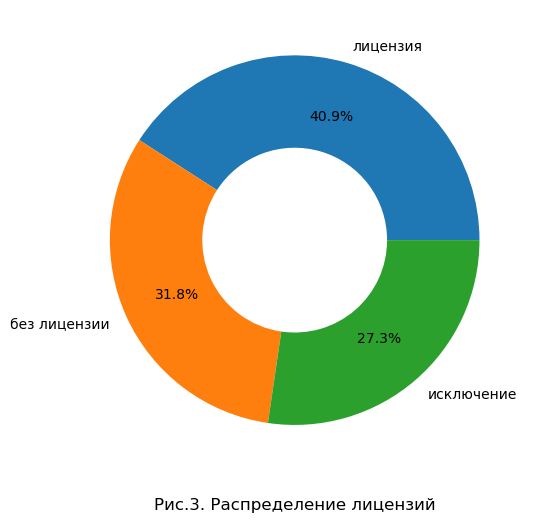

In [23]:
def classify_license(license_value):
    if pd.isna(license_value):
        return 'без лицензии' 
    elif 'Exempt' in str(license_value):
        return 'исключение'
    else:
        return 'лицензия' 

# применяем функцию к каждому значению в колонке `license`
listings['license_type'] = listings['license'].apply(classify_license)

# подсчитываем количество наблюдений для каждого типа лицензии
license_counts = listings['license_type'].value_counts()

# создание круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(
    license_counts, # данные для диаграммы
    labels = license_counts.index, # название категорий
    autopct ='%1.1f%%', #о тображение процентов с точностью до 1 знака
    pctdistance = 0.7,
    colors = sns.color_palette('tab10'),  # цвета стандартные
    wedgeprops ={'width': 0.5} # добавляем дырку
    )

plt.title('Рис.3. Распределение лицензий', y = -0.1)
plt.show()

### Cтолбчатая диаграмма, показывающая число квартир в зависимости от минимального срока аренды 
Примечательно, что для краткосрочной аренды (до 30 дней) требуется специальная лицензия.
Комментарий к результату: образовались две группы-скопления наблюдений: промежуток 1-7 дней и промежуток 30-33 дней. Первый промежуток – это те арендодатели, которые смогли оформить себе лицензию и могут законодательно сдавать жилое помещение на 1 день; второй промежуток – те, кто лицензию не оформили и могут сдавать только на 30+ дней. Заметно разное понимание арендодателями трактовки «до 30 дней»: часть считает, что на 30 дней включительно лицензия уже не нужна.

/var/folders/6p/8d5pp0rd4_sbkn9mzjsq45rr0000gn/T/ipykernel_2918/1517924400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


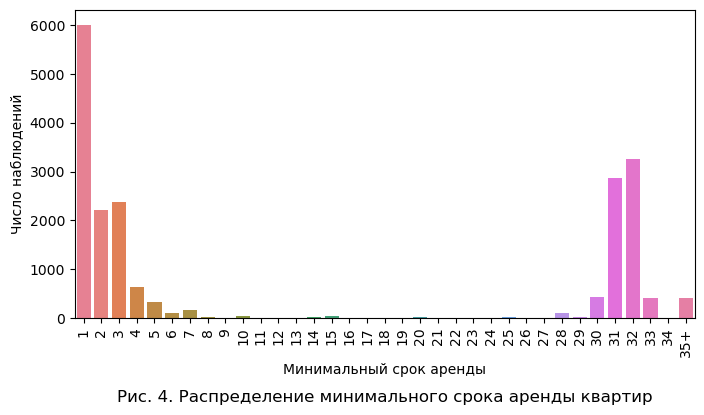

In [29]:
# создание бинов
bins = list(range(1, 35)) + [35, float('inf')]  # бины от 1 до 34 отдельно и 35+
labels = list(range(1, 35)) + ['35+']  # метки от 1 до 34 и 35+

# применение бинов к данным
listings['minimum_nights_binned'] = pd.cut( 
    listings['minimum_nights'], 
    bins=bins, 
    labels=labels, 
    right=False
    ) 

plt.figure(figsize=(8, 4))
sns.countplot(
    data=listings,
    x ='minimum_nights_binned', 
    palette ='husl', 
    legend = False  
    )
plt.title('Рис. 4. Распределение минимального срока аренды квартир', y = - 0.3)
plt.xlabel('Минимальный срок аренды')
plt.xticks(rotation = 90) # чтобы значения по оси х были перевернуты и их было удобнее читать
plt.ylabel('Число наблюдений')
plt.show()

### Cтолбчатая диаграмма, показывающая число квартир в зависимости от того, сколько квартир управляется одним арендодателем

Комментарий к результату: присутствует значительная полярность. Около 8000 наблюдений соответствует числу квартир 10+ в управлении одного арендатора (для этого типа арендаторов это, возможно, основной, а не дополнительный источник дохода)

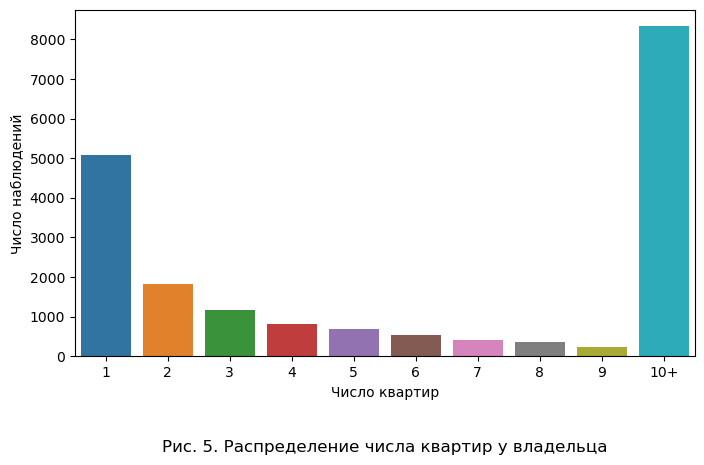

In [32]:
# создание бинов для переменной calculated_host_listings_count
bins = list(range(1, 10)) + [10, float('inf')]  # от 1 до 9 отдельно и 10+
labels = list(range(1, 10)) + ['10+']  # метки от 1 до 9 и 10+

# cоздание новой колонки с категориями бинов
listings['host_listings_binned'] = pd.cut(
    listings['calculated_host_listings_count'], 
    bins = bins, 
    labels=labels,
    right=False
)

plt.figure(figsize=(8, 4.5))
sns.countplot(
    data=listings, 
    x='host_listings_binned', # ось x для вертикальных столбцов
    hue = 'host_listings_binned',
    palette = 'tab10',
    legend = False
    )

plt.title('Рис. 5. Распределение числа квартир у владельца', y = -0.3)
plt.xlabel('Число квартир')
plt.ylabel('Число наблюдений')
plt.show()

### Создание объект-карты для района Барселоны el Barri Gòtic

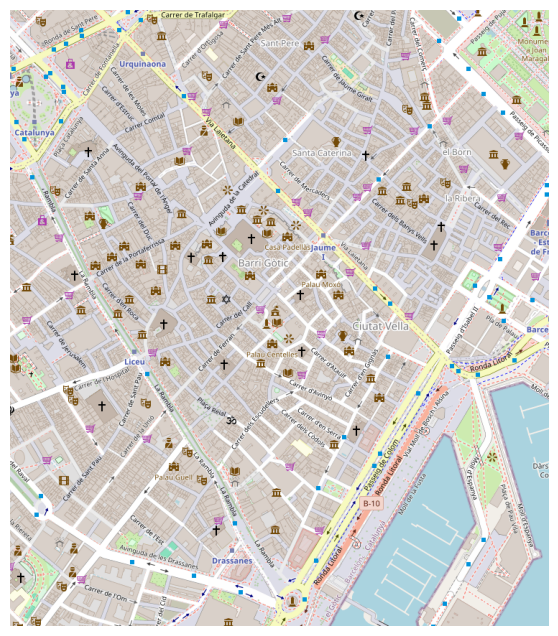

In [35]:
my_neighbourhood = listings[listings['neighbourhood'] == 'el Barri Gòtic'] # создаем датафрейм только для выбранного района

# находим границы карты - минимальные и максимальные широта и долгота 
min_lon = min(my_neighbourhood['longitude'])
max_lon = max(my_neighbourhood['longitude'])
min_lat = min(my_neighbourhood['latitude'])
max_lat = max(my_neighbourhood['latitude'])

import nest_asyncio as na
na.apply()

# создание карты с найденными границами и уровнем зума
padding = 0.001
mmap = geotiler.Map(extent=(min_lon - padding, min_lat - padding, max_lon + padding, max_lat + padding), zoom=16)
img = geotiler.render_map(mmap)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

### Перекодировка координат квартир в координаты диаграммы

In [40]:
x = []
y = []
for i, j in zip(my_neighbourhood['longitude'], my_neighbourhood['latitude']): 
    x_current, y_current = mmap.rev_geocode((i, j)) 
    x.append(x_current)
    y.append(y_current)

print(x[:5]) 

my_neighbourhood.loc[:, 'img_latitude'], my_neighbourhood.loc[:, 'img_longitude'] = zip(*my_neighbourhood[['longitude', 'latitude']].apply(mmap.rev_geocode, axis=1))
# через apply применяем функцию ко всем строкам из датафрейма, задавая долготу и широту
# axis = 1: применяем функцию именно к строкам

[271.26924088969827, 320.6688213329762, 401.2926648892462, 371.9325368888676, 353.2911857776344]


###  Отображение квартир на карте

Раскрасила полученную диаграмму в разные цвета в зависимости от количества отзывов.

Комментарий к результату: много предложений в районе и у большинства квартир много отзывов, то есть район пользуется популярностью.

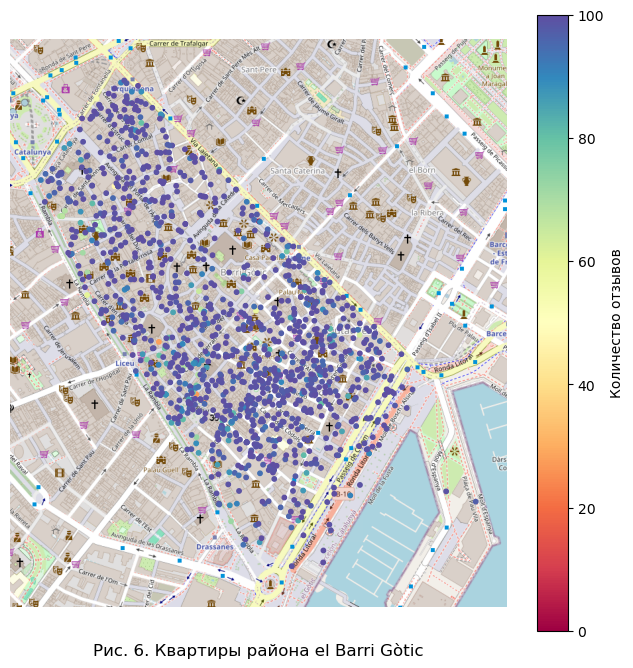

In [44]:
occ = my_neighbourhood['number_of_reviews'] # в качестве параметра берем количество отзывов
colors = (100*(occ.max() - occ)/(occ.max()-occ.min())).astype(int)

plt.figure(figsize = (8, 8)) 
plt.imshow(img) 

# рисуем точки, красим их разными цветами, палитра Spectral, s=10 - для размера точек
plt.scatter(my_neighbourhood['img_latitude'], my_neighbourhood['img_longitude'], c = colors, cmap = 'Spectral', s = 10) 
plt.axis('off')
cbar = plt.colorbar() # для интерпретации цвета добавим шкалу цвета
cbar.set_label('Количество отзывов')
plt.title('Рис. 6. Квартиры района el Barri Gòtic', y = -0.1)
plt.show()

### Диаграмма рассеивания для цены аренды и занятости
Комментарий к результату: сильной корреляции не наблюдается

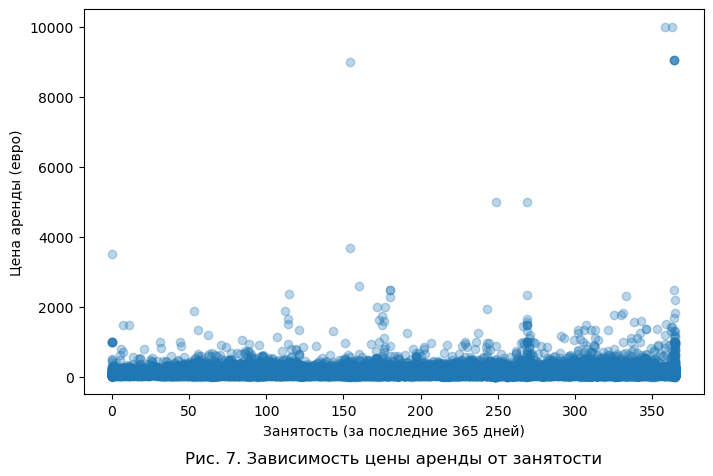

In [47]:
plt.figure(figsize=(8, 5))

# строим диаграмму рассеивания с линией регрессии, линия регрессии не видна
sns.regplot(
    data = listings, 
    x= 'availability_365',
    y= 'price' ,     
    scatter_kws={'alpha': 0.3}, # alpha задает прозрачность, иначе из-за скопления ничего не видно
    )

plt.title('Рис. 7. Зависимость цены аренды от занятости', y = -0.2)
plt.xlabel('Занятость (за последние 365 дней)')
plt.ylabel('Цена аренды (евро)')
plt.show()

### Cтековая столбчая диаграмма распределения типов квартир в зависимости от группы районов Барселоны

Комментарий к результату: в 8 группах районов из 10 более половины составляет категория ‘entire home/apt’, исключения – Nou Barris, Sant Andreu. В Sant Andreu также самая большая доля категории ‘shared room’

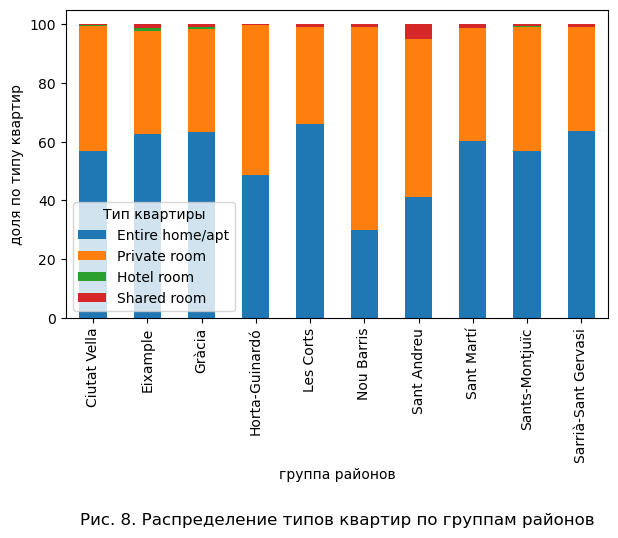

In [50]:
group_data = listings.groupby(['neighbourhood_group', 'room_type']).size().unstack()
# группируем данные по 2 столбцам: neighbourhood_group и room_typе
#.size(): подсчет количества наблюдений в каждой группе
#.unstack(): создаем таблицу, где строки - neighbourhood_group, а столбцы — room_typе, значения клеточек - количество квартир

# считаем доли для каждого района и типа квартир, суммируем по строкам, делим каждое значение на сумму соответствующей строки
group_data_percent = group_data.div(group_data.sum(axis=1), axis=0) * 100
order = ['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'] # задаем нужный порядок
group_data_percent = group_data_percent[order]

# строим стековую диаграмму
group_data_percent.plot (kind='bar', stacked=True, figsize=(7, 4))

plt.title('Рис. 8. Распределение типов квартир по группам районов',  y = -0.7)
plt.xlabel('группа районов')
plt.ylabel('доля по типу квартир')
plt.legend(title ='Тип квартиры')
plt.show()

### Cредняя занятость по группам районов
Самая популярная группа районов – Sarrià-Sant Gervasi

In [53]:
avg_availability = listings.groupby('neighbourhood_group')['availability_365'].mean()

print(avg_availability) # выводим средние значения по району
print('\n', avg_availability.idxmax()) # выводим район с максимальным значением, это Sarrià-Sant Gervasi

neighbourhood_group
Ciutat Vella           173.699452
Eixample               183.318221
Gràcia                 181.335148
Horta-Guinardó         162.426087
Les Corts              144.898010
Nou Barris             161.977376
Sant Andreu            154.446541
Sant Martí             172.691925
Sants-Montjuïc         171.025038
Sarrià-Sant Gervasi    195.797361
Name: availability_365, dtype: float64

 Sarrià-Sant Gervasi


### Cредняя цена аренды квартиры в зависимости от группы районов Барселоны

Комментарий к результату: максимальная средняя цена – в районе Eixample, тогда как максимальные цены – в Les Corts и Ciutat Vella.

In [58]:
avg_price = listings.groupby('neighbourhood_group')['price'].mean().reset_index()
avg_price['Price calculations'] = 'average price'

max_price = listings.groupby('neighbourhood_group')['price'].max().reset_index()
max_price['Price calculations'] = 'max price'


price_data = pd.concat([max_price, avg_price])

price_pivot = price_data.pivot(index ='neighbourhood_group', columns='Price calculations', values='price')
price_pivot = price_pivot.sort_values(by='average price', ascending=False) 

print(price_pivot)

Price calculations   average price  max price
neighbourhood_group                          
Eixample                199.697576     9000.0
Les Corts               179.356250     9999.0
Sant Martí              177.820318     5000.0
Sants-Montjuïc          170.506641     9059.0
Gràcia                  157.574815     1487.0
Sarrià-Sant Gervasi     153.558426     1214.0
Ciutat Vella            137.045547     9999.0
Horta-Guinardó          110.694954     1185.0
Sant Andreu              87.226496     1580.0
Nou Barris               74.430303     1185.0


### Распределение цен аренды квартиры в зависимости от группы районов Барселоны в виде ящичной и скрипичной диаграмм

Различия боксплота и violin plot в основном по двум параметрам: медиана и выбросы. Boxplot явно показывает медиану, тогда как в Violin plot это менее очевидно. Boxplot выделяет выбросы как отдельные точки, что позволяет легко идентифицировать их, у Violin plot это сложнее различить. 

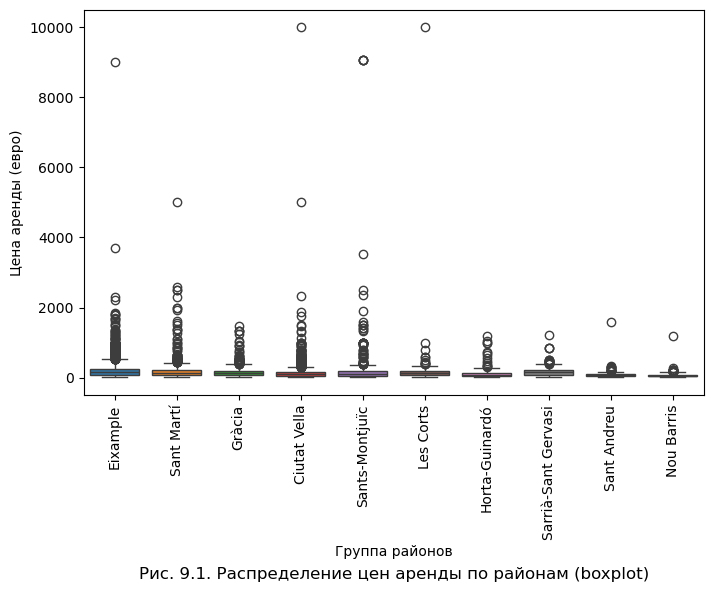

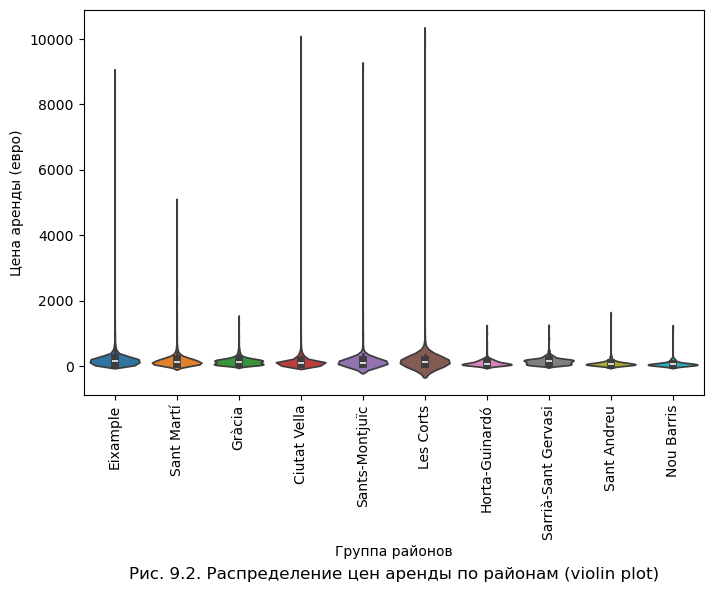

In [62]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=listings, 
    x='neighbourhood_group', 
    y='price', 
    hue= 'neighbourhood_group',
    palette='tab10'
)

plt.title('Рис. 9.1. Распределение цен аренды по районам (boxplot)', y = -0.5)
plt.xlabel('Группа районов')
plt.ylabel('Цена аренды (евро)')
plt.xticks(rotation=90) 
plt.show()


plt.figure(figsize=(8, 5))
sns.violinplot(
    data=listings, 
    x='neighbourhood_group', 
    y='price', 
    hue= 'neighbourhood_group',
    palette='tab10'
)
plt.title('Рис. 9.2. Распределение цен аренды по районам (violin plot)', y = -0.5)
plt.xlabel('Группа районов')
plt.ylabel('Цена аренды (евро)')
plt.xticks(rotation=90)
plt.show()

### Какие арендодатели заработали за последний год больше всего за сдачу квартиры/квартир в аренду

Видимо, это юр лица в основном

                   host_name  total_income  num_listings
24       Acomodis Apartments    27413081.0           233
6     AB Apartment Barcelona    19851890.0           191
3220                    Ukio    14812358.0           437
2661      Pierre Et Vacances    13189904.0             4
1254      Habitat Apartments     9760052.0           141
3045            Stay U-Nique     9162017.0           166
3086                SweetInn     9128078.0           196
950                  Enrique     5212707.0            87
77                    Albert     5190431.0            88
383                Barcelona     4930068.0            46


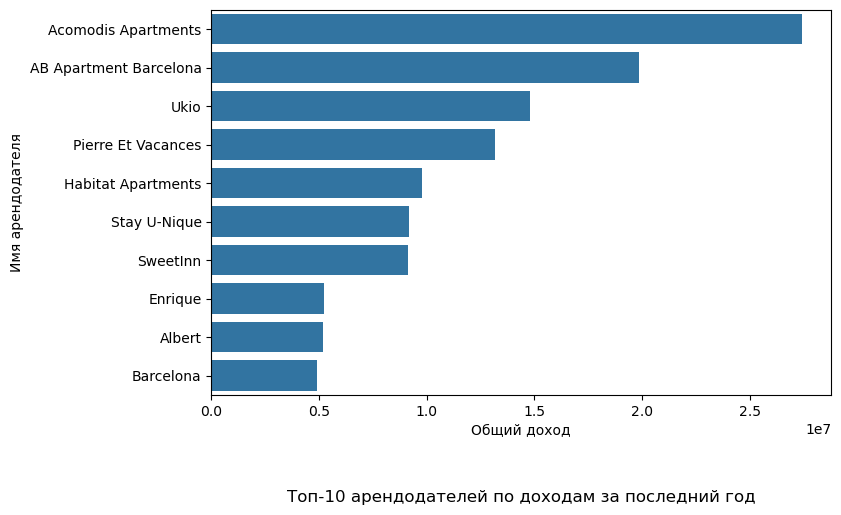

In [65]:
listings['income'] = listings['price'] * listings['availability_365'] # рассчитываем доход по каждой квартиры

# группируем данные по арендодателю и рассчитываем необходимые значения
top_hosts = (listings
             .groupby('host_name')
             .agg(total_income=('income', 'sum'),
                  num_listings=('id', 'nunique'))
             .reset_index()
             .sort_values(by='total_income', ascending=False)
             .head(10))

# выводим таблицу, где в порядке убывания расположены имена арендодателей, 
#суммарный доход за последний год, а также количество их объявлений
print(top_hosts)

# построение столбчатой диаграммы по топ-10 арендодателей по доходам
plt.figure(figsize=(8, 5))
sns.barplot(data=top_hosts, x='total_income', y='host_name')
plt.title('Топ-10 арендодателей по доходам за последний год', y=-0.3)
plt.xlabel('Общий доход')
plt.ylabel('Имя арендодателя')

plt.show()